Install needed libraries (May cause session restart in Colab)

In [3]:
!pip install -U sentence-transformers scikit-learn pandas pyarrow matplotlib phonenumbers tldextract
!pip install fuzzywuzzy python-levenshtein

  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 146.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
 

Compile libpostal C library and install python version (May take a few minutes)

In [2]:
!sudo apt-get install curl autoconf automake libtool pkg-config
!git clone https://github.com/openvenues/libpostal
%cd libpostal
!./bootstrap.sh
!./configure --datadir="/content"
!make -j4
!sudo make install
!sudo ldconfig

!sudo apt-get install python3
!sudo apt-get install python3-pip

!python3 --version
!pip3 --version

!pip3 install postal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
autoconf is already the newest version (2.71-2).
autoconf set to manually installed.
automake is already the newest version (1:1.16.5-1.3).
automake set to manually installed.
curl is already the newest version (7.81.0-1ubuntu1.21).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
Suggested packages:
  libtool-doc gcj-jdk
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libtool pkg-config
0 upgraded, 2 newly installed, 2 to remove and 41 not upgraded.
Need to get 212 kB of archives.
After this operation, 1,223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.

Import modules and Set up CUDA device

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import phonenumbers
import tldextract
import json
import re # Used for cleaning the input string before parsing
from sklearn.ensemble import GradientBoostingClassifier
from rapidfuzz import fuzz

import torch

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint # For integer distributions
from scipy.stats import uniform as sp_uniform # For float distributions


# Scikit-learn imports for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_curve, auc, classification_report, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, PrecisionRecallDisplay

import time
import gc

# SentenceTransformers imports
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from postal.parser import parse_address
from postal.expand import expand_address

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device in use: {device.upper()}")

Device in use: CUDA


Define Helper Functions

In [3]:
def safe_json_parse(text, key):
    # A placeholder for the function that extracts a value from JSON/complex strings
    if not text: return ""
    try:
        data = json.loads(text)
        if isinstance(data, dict): return str(data.get(key, ""))
        if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
            return str(data[0].get(key, ""))
        return ""
    except (json.JSONDecodeError, TypeError):
        # When JSON parsing fails, it may return the original text if it's the only value
        # For the purpose of locality extraction, we should NOT return the full text here.
        return ""

def normalize_phone(text, country_code):
    """
    Extract and normalize phone numbers to E.164 format (+CCNNNNNNNNN) using the provided country code.
    """
    if not text or not country_code:
        return ""
    try:
        data = json.loads(text)
        phone_str = None

        # Extract the raw phone string from the list structure (similar to previous logic)
        if isinstance(data, list) and len(data) > 0:
            first_element = data[0]
            if isinstance(first_element, str):
                phone_str = first_element
            elif isinstance(first_element, dict):
                phone_str = first_element.get('value', first_element.get('phone'))

            if phone_str and isinstance(phone_str, str):
                # 1. Attempt to parse using the known country_code
                parsed_num = phonenumbers.parse(phone_str, country_code)

                # 2. If valid, format it to the unique E.164 string
                if phonenumbers.is_valid_number(parsed_num):
                    return phonenumbers.format_number(parsed_num, phonenumbers.PhoneNumberFormat.E164)

        return ""
    except (json.JSONDecodeError, TypeError, phonenumbers.NumberParseException):
        # Catch any data parsing or number parsing errors
        return ""

# Assuming you've already defined safe_json_parse, add this simple extraction function:
def extract_country_code(text):
    """
    Safely extracts the two-letter country code from the address JSON.
    """
    if not text:
        return ""
    try:
        data = json.loads(text)
        if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
            return data[0].get('country', "")
        return ""
    except (json.JSONDecodeError, TypeError):
        return ""

def get_base_domain(text_list):
    """
    Extract and normalize websites to their domain
    """
    if not text_list:
        return ""

    try:
        data = json.loads(text_list)

        if isinstance(data, list) and len(data) > 0:
            url_string = None
            first_element = data[0]

            url_string = first_element

            if url_string and isinstance(url_string, str):
                # Use tldextract to get the domain and TLD (ignoring subdomains)
                extracted = tldextract.extract(url_string)

                # Check if we got a valid domain back
                if extracted.domain and extracted.suffix:
                    return f"{extracted.domain}.{extracted.suffix}"

        return ""
    except (json.JSONDecodeError, TypeError):
        return ""

def create_text_representation(row, column, key, base=False):
    """
    Create a clean, unified text description for a place record.
    """
    prefix = 'base_' if base else ''

    text = safe_json_parse(row[f'{prefix}{column}'], key=key)

    if not text:
      text = ""

    # Concatenate non-empty fields into one text string
    parts = [part for part in [text] if part]
    return ", ".join(parts)

def get_all_categories(text):
    """
    Safely parses the category JSON and returns a set containing the primary
    category and all alternate categories (lowercased and cleaned).
    """
    categories = set()
    if not text:
        return categories
    try:
        data = json.loads(text)

        if isinstance(data, dict):
            # 1. Add Primary Category
            primary = data.get('primary')
            if primary:
                categories.add(primary.lower().strip())

            # 2. Add Alternate Categories
            alternates = data.get('alternate')
            if isinstance(alternates, list):
                for alt in alternates:
                    if isinstance(alt, str):
                        categories.add(alt.lower().strip())

        return categories

    except (json.JSONDecodeError, TypeError):
        return categories

def calculate_fuzzy_features(name1: str, name2: str) -> dict:
    """
    Calculates key fuzzy ratios between two strings, normalized to 0.0 to 1.0.
    """
    # Ensure inputs are clean (lowercase and stripped of leading/trailing space)
    str1 = str(name1).lower().strip()
    str2 = str(name2).lower().strip()

    # Check if either string is empty to prevent errors or false high scores
    if not str1 or not str2:
        return {
            "ratio": 0.0,
            "partial_ratio": 0.0,
            "token_set_ratio": 0.0
        }

    return {
        # 1. Standard Similarity: Measures overall character similarity
        "ratio": fuzz.ratio(str1, str2) / 100.0,

        # 2. Partial Similarity: Finds the best matching substring (good for long vs. short)
        "partial_ratio": fuzz.partial_ratio(str1, str2) / 100.0,

        # 3. Token Set Ratio: Ignores word order and redundant/extra words (BEST for record linkage)
        "token_set_ratio": fuzz.token_set_ratio(str1, str2) / 100.0,
    }

def normalize_address(address_str):
    """
    Uses libpostal to generate a standardized list of address representations.
    We return the first (usually the most common) expanded form.
    """
    if pd.isna(address_str):
        return address_str

    # Generate expanded forms (e.g., 'st' instead of 'street', lowercase)
    expanded_forms = expand_address(address_str)

    # Return the first (most common) expanded form
    return expanded_forms[0] if expanded_forms else address_str

Data Loading and Cleaning

In [5]:
file_path = "samples_3k_project_c_updated.parquet"
try:
    df = pd.read_parquet(file_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please upload it before proceeding.")

# Apply the function to create two new columns
tqdm.pandas(desc="Creating text representations")
df['name'] = df.apply(lambda row: create_text_representation(row, "names", "primary", base=False), axis=1)
df['base_name'] = df.apply(lambda row: create_text_representation(row, "names", "primary", base=True), axis=1)

df['name_match'] = (
    df['name'].astype(str).str.lower() ==
    df['base_name'].astype(str).str.lower()
)

df['address'] = df.apply(lambda row: create_text_representation(row, "addresses", "freeform", base=False), axis=1)
df['base_address'] = df.apply(lambda row: create_text_representation(row, "addresses", "freeform", base=True), axis=1)

df['confidence_product'] = df['confidence'] * df['base_confidence']

df['country_code'] = df.apply(lambda row: create_text_representation(row, "addresses", "country", base=False), axis=1)
df['base_country_code'] = df.apply(lambda row: create_text_representation(row, "addresses", "country", base=True), axis=1)

# apply normalization to your existing address columns

df['address'] = df['address'].apply(normalize_address)
df['base_address'] = df['base_address'].apply(normalize_address)

# parse and create a text representation for the necessary columns

df['category'] = df.apply(lambda row: create_text_representation(row, "categories", "primary", base=False), axis=1)
df['base_category'] = df.apply(lambda row: create_text_representation(row, "categories", "primary", base=True), axis=1)

df['locality'] = df.apply(lambda row: create_text_representation(row, "addresses", "locality", base=False), axis=1)
df['base_locality'] = df.apply(lambda row: create_text_representation(row, "addresses", "locality", base=True), axis=1)

df['country'] = df.apply(lambda row: create_text_representation(row, "addresses", "country", base=False), axis=1)
df['base_country'] = df.apply(lambda row: create_text_representation(row, "addresses", "country", base=True), axis=1)

df['postcode'] = df.apply(lambda row: create_text_representation(row, "addresses", "postcode", base=False), axis=1)
df['base_postcode'] = df.apply(lambda row: create_text_representation(row, "addresses", "postcode", base=True), axis=1)

df['region'] = df.apply(lambda row: create_text_representation(row, "addresses", "region", base=False), axis=1)
df['base_region'] = df.apply(lambda row: create_text_representation(row, "addresses", "region", base=True), axis=1)

# Compare normalized phone numbers

df['candidate_phone_norm'] = df.apply(
    lambda row: normalize_phone(row['phones'], row['country_code']),
    axis=1
)
df['base_phone_norm'] = df.apply(
    lambda row: normalize_phone(row['base_phones'], row['base_country_code']),
    axis=1
)

df['phone_match'] = (
    (df['candidate_phone_norm'] != "") &
    (df['base_phone_norm'] != "") &
    (df['candidate_phone_norm'] == df['base_phone_norm'])
).astype(int)

print('Total phone matches:', df['phone_match'].sum())

df['exact_phone_match_predict'] = (
    (df['phone_match'] == 1) &

    (df['label'] == 1)
)

print("Exact phone match correct predictions:", df['exact_phone_match_predict'].sum())

# Compare websites for binary match feature
df['website'] = df['websites'].apply(get_base_domain)
df['base_website'] = df['base_websites'].apply(get_base_domain)

df['website_match'] = (
    (df['base_website'] != "") &
    (df['website'] != "") &
    (df['website'] == df['base_website'])
).astype(int)

# Match any categories
df['category_set'] = df['categories'].apply(get_all_categories)
df['base_category_set'] = df['base_categories'].apply(get_all_categories)

df['category_match'] = df.apply(
    lambda row: 1 if row['category_set'].intersection(row['base_category_set']) else 0,
    axis=1
)

# Get the differences in length of the names of the two places
df['name_length_diff'] = np.abs(
    df['name'].str.len() - df['base_name'].str.len()
)

# Get the differences in length of the names of the two places
df['name_word_diff'] = np.abs(
    df['name'].apply(lambda x: len(x.split())) - df['base_name'].apply(lambda x: len(x.split()))
)

# Apply the function to create a DataFrame of the scores
fuzzy_scores_df = df.apply(
    lambda row: pd.Series(
        calculate_fuzzy_features(row['name'], row['base_name'])
    ),
    axis=1
)

df = pd.concat([df, fuzzy_scores_df], axis=1)

# Apply the function to create a DataFrame of the scores
fuzzy_scores_addr_df = df.apply(
    lambda row: pd.Series(
        calculate_fuzzy_features(row['address'], row['base_address'])
    ),
    axis=1
)

fuzzy_scores_addr_df = fuzzy_scores_addr_df.rename(columns={
    'ratio': 'addr_ratio',
    'partial_ratio': 'addr_partial_ratio',
    'token_set_ratio': 'addr_token_set_ratio'
})

df = pd.concat([df, fuzzy_scores_addr_df], axis=1)

Dataset loaded successfully. Shape: (3000, 23)
Total phone matches: 1183
Exact phone match correct predictions: 1084


Parse the house number and road name

In [6]:
TARGET_COMPONENTS = ['house_number', 'road']
from typing import Dict, List, Tuple

def get_parsed_component_dict(address_string: str) -> Dict[str, str]:
    """
    Parses an address string and returns a dictionary containing only the
    house_number and road (street name), converted to uppercase.
    """
    if not address_string:
        return {}

    parsed_list: List[Tuple[str, str]] = parse_address(address_string)

    # Initialize dictionary with None for all target components
    components = {comp: None for comp in TARGET_COMPONENTS}

    for value, label in parsed_list:
        if label in TARGET_COMPONENTS:
            # We only keep the first instance of a component
            if components[label] is None:
                # Store cleaned, stripped, and uppercased value
                components[label] = str(value).strip().upper()

    return components

def create_road_match_features(df):
    """
    Applies libpostal parsing to 'address' and 'base_address' and creates
    two binary match features: 'match_house_num' and 'match_road'.
    """

    # 1. Apply parsing to both address columns to get structured components

    # Parse primary address ('address')
    parsed_a = df['address'].apply(get_parsed_component_dict)
    df['num'] = parsed_a.apply(lambda x: x.get('house_number'))
    df['road'] = parsed_a.apply(lambda x: x.get('road'))

    # Parse base address ('base_address')
    parsed_b = df['base_address'].apply(get_parsed_component_dict)
    df['base_num'] = parsed_b.apply(lambda x: x.get('house_number'))
    df['base_road'] = parsed_b.apply(lambda x: x.get('road'))

    # 2. Create the two match features (0 or 1)

    # Feature 1: Exact House Number Match
    # We must first ensure all values are strings and clean up NaNs/None for reliable comparison
    num_a = df['num'].astype(str).str.strip().fillna('')
    num_b = df['base_num'].astype(str).str.strip().fillna('')

    # 'match_house_num' is 1 only if both extracted numbers are non-empty and identical
    df['match_num'] = ((num_a != '') & (num_a == num_b)).astype(int)
    df['mismatch_num'] = ((num_a != '') & (num_b != '') & (num_a != num_b)).astype(int)

    # Feature 2: Exact Road/Street Name Match
    road_a = df['road'].astype(str).str.strip().fillna('')
    road_b = df['base_road'].astype(str).str.strip().fillna('')

    # 'match_road' is 1 only if both extracted road names are non-empty and identical
    df['match_road'] = ((road_a != '') & (road_a == road_b)).astype(int)

    return df

df = create_road_match_features(df)

Split data into train and test

In [7]:
print(f"\nLabel distribution:\n{df['label'].value_counts()}")
print(f"Positive sample (match) ratio: {df['label'].mean():.2%}")

X = df[['name', 'base_name', 'address', 'base_address', 'phone_match',
        'match_num', 'category', 'base_category',
        'locality', 'base_locality', 'region', 'base_region', 'confidence_product',
        'addr_partial_ratio', 'addr_token_set_ratio', 'partial_ratio', 'token_set_ratio',
        'name_length_diff', 'website_match', 'category_match', 'mismatch_num',
        'country', 'base_country', 'name_word_diff', 'road', 'base_road'
        ]]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

non_us_mask = (X_test['country'] != 'US')
missing_data_mask = (X_test['address'] == '') | (X_test['name'] == '')

y_test_non_us = y_test[non_us_mask]

print(y_test_non_us.size)

y_test_missing_data = y_test[missing_data_mask]
print(y_test_missing_data.size)



Label distribution:
label
1.0    1809
0.0    1191
Name: count, dtype: int64
Positive sample (match) ratio: 60.30%
315
31


Login to HuggingFace if using restricted model

In [10]:
from huggingface_hub import login
login()

In [9]:
# Processes features in the dataframe for training and testing
def process_feature(X_set: pd.DataFrame, set_name: str, embedder: SentenceTransformer, column: str) -> Tuple[Dict, List[np.ndarray], np.ndarray]:

    text_A = X_set[column].apply(lambda x: x.strip() if x else '')
    text_B = X_set["base_" + column].apply(lambda x: x.strip() if x else '')

    empty_mask = (text_A == '') & (text_B == '')

    instruction = ''
    emb = None
    base_emb = None
    # Different embedding format using multiple columns for address column
    if column == 'address':
      emb = embedder.encode(
          (text_A + X_set['locality'] + X_set['region'] + X_set['country']).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=embedder.device
      )
      base_emb = embedder.encode(
          (text_B + X_set['base_locality'] + X_set['base_region'] + X_set['base_country']).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=embedder.device
      )
    else:
      emb = embedder.encode(
          (instruction + text_A).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=embedder.device
      )
      base_emb = embedder.encode(
          (instruction + text_B).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=embedder.device
      )
    sim_scores = cos_sim(emb, base_emb).diag().cpu().numpy()

    return [sim_scores]

def reshape_similarities(sims):
  reshaped_sims = []
  for sim in sims:
      reshaped_sims.append(sim.reshape(-1, 1))
  return reshaped_sims

def reshape_and_stack_features(X_data, sim_list, discrete_cols):
    """Reshapes and stacks all semantic and discrete features from the full dataset."""
    discrete_features_list = [X_data[col].values.reshape(-1, 1) for col in discrete_cols]

    return np.hstack(discrete_features_list + sim_list)

classifier = GradientBoostingClassifier(
    n_estimators=496, learning_rate=0.01, max_depth=6, subsample=0.7,
    max_features=0.7, min_samples_leaf=7, random_state=42
)

Test a wide array of small models and their performance


--- Testing Model: intfloat/multilingual-e5-base ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.8981
  F1-Score (Non-US Data): 0.8870
  F1-Score (Missing Data): 0.7368
  Average F1 CV Score: 0.8961
  Accuracy: 0.8733
  Accuracy (Non-US Data): 0.8730
  Accuracy (Missing Data): 0.8387
  PR-AUC:   0.9676
  PR-AUC (Missing Data): 0.7873
  PR-AUC (Non-US Data): 0.9129
  Total Test Set Processing Time: 1.47s


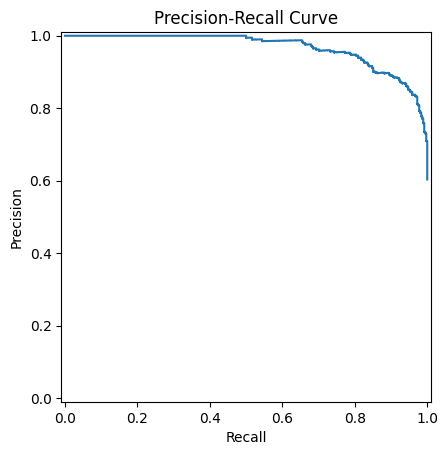



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 49 (Incorrect Conflations)
                                                   name  \
863                      Produkta Motor Group Nelspruit   
2571                               CIBC Branch with ATM   
1866                                   Wells Fargo Bank   
1825                                          Axis Bank   
1906                                         McDonald's   
2346                              Hair Designs by Diane   
1938                                             Subway   
2734                         Teofilo Kisanji University   
1824  The University of Kansas Health System KU MedW...   
2602                    บริษัท ไทยสมเด็จ เซอร์วิส จำกัด   

                                              base_name  \
863   Produkta Motor Group Jeep Nelspruit Alfa Romeo...   
2571                                               CIBC   
1866                                    Wells Fargo ATM   
1825              

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.9044
  F1-Score (Non-US Data): 0.9020
  F1-Score (Missing Data): 0.8000
  Average F1 CV Score: 0.8984
  Accuracy: 0.8817
  Accuracy (Non-US Data): 0.8889
  Accuracy (Missing Data): 0.8710
  PR-AUC:   0.9706
  PR-AUC (Missing Data): 0.8323
  PR-AUC (Non-US Data): 0.9219
  Total Test Set Processing Time: 4.55s


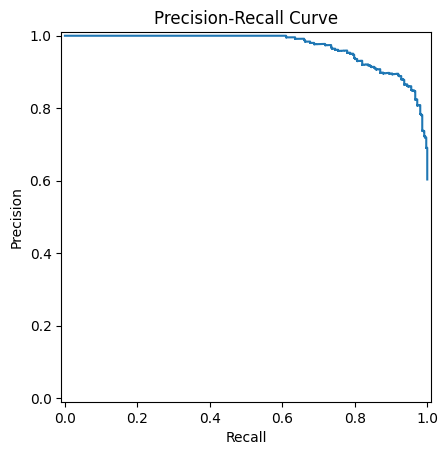



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 45 (Incorrect Conflations)
                                          name  \
1938                                    Subway   
2361                   Santiago Canyon College   
2734                Teofilo Kisanji University   
1860                               Vinzenzmurr   
2490  Kreissparkasse Ludwigsburg - Geldautomat   
395                        Lotto-Annahmestelle   
1429                            Shell Recharge   
2618                           Royale Pharmacy   
2092                                 Starbucks   
2090               Başakşehir 4. Etap 2. Kısım   

                               base_name  \
1938                              Subway   
2361       Santiago Canyon College - Gym   
2734  Teofilo Kisanji University Library   
1860                         vinzenzmurr   
2490          Kreissparkasse Ludwigsburg   
395                  Lotto-Annahmestelle   
1429                      Shell Recharge   
2

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.9000
  F1-Score (Non-US Data): 0.8852
  F1-Score (Missing Data): 0.6667
  Average F1 CV Score: 0.8918
  Accuracy: 0.8767
  Accuracy (Non-US Data): 0.8698
  Accuracy (Missing Data): 0.8065
  PR-AUC:   0.9673
  PR-AUC (Missing Data): 0.7395
  PR-AUC (Non-US Data): 0.9098
  Total Test Set Processing Time: 1.25s


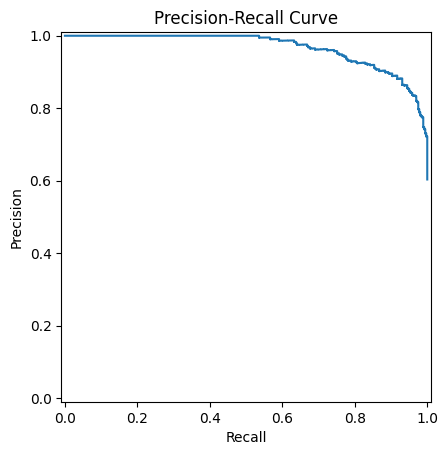



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 45 (Incorrect Conflations)
                                name  \
2092                       Starbucks   
1742        Green Valley Grocery #47   
1847                         Walmart   
2437                       Starbucks   
2099         Barmenia Versicherungen   
863   Produkta Motor Group Nelspruit   
2784         Barmenia Versicherungen   
2753      U-Haul Neighborhood Dealer   
1612            LibertyX Bitcoin ATM   
1938                          Subway   

                                              base_name  \
2092                                          Starbucks   
1742                               Green Valley Grocery   
1847                                            Walmart   
2437                                          Starbucks   
2099              Barmenia Versicherung - Oliver Schulz   
863   Produkta Motor Group Jeep Nelspruit Alfa Romeo...   
2784                Barmenia Versicherung - Thomas

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/611M [00:00<?, ?B/s]

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.9005
  F1-Score (Non-US Data): 0.8920
  F1-Score (Missing Data): 0.7778
  Average F1 CV Score: 0.8956
  Accuracy: 0.8767
  Accuracy (Non-US Data): 0.8794
  Accuracy (Missing Data): 0.8710
  PR-AUC:   0.9684
  PR-AUC (Missing Data): 0.8359
  PR-AUC (Non-US Data): 0.9177
  Total Test Set Processing Time: 1.98s


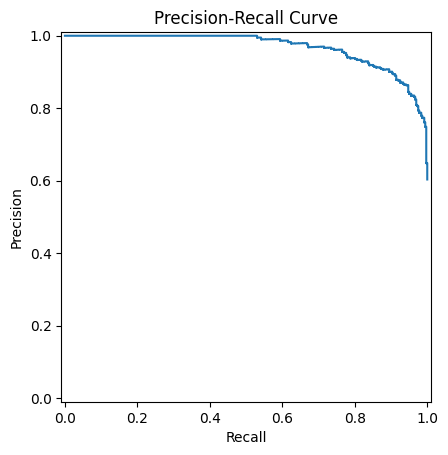



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 47 (Incorrect Conflations)
                                  name  \
1827  San Jose Unified School District   
1429                    Shell Recharge   
2437                         Starbucks   
1906                        McDonald's   
1866                  Wells Fargo Bank   
718        Blue Rhino Propane Exchange   
2079               Lovely Hair & Nails   
2346             Hair Designs by Diane   
395                Lotto-Annahmestelle   
2602   บริษัท ไทยสมเด็จ เซอร์วิส จำกัด   

                                             base_name  \
1827  San Jose Unified School District Culinary Center   
1429                                    Shell Recharge   
2437                                         Starbucks   
1906                                        McDonald's   
1866                                   Wells Fargo ATM   
718                        Blue Rhino Propane Exchange   
2079                         Lovely

modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.8934
  F1-Score (Non-US Data): 0.8761
  F1-Score (Missing Data): 0.7368
  Average F1 CV Score: 0.8988
  Accuracy: 0.8700
  Accuracy (Non-US Data): 0.8635
  Accuracy (Missing Data): 0.8387
  PR-AUC:   0.9690
  PR-AUC (Missing Data): 0.7873
  PR-AUC (Non-US Data): 0.9094
  Total Test Set Processing Time: 5.88s


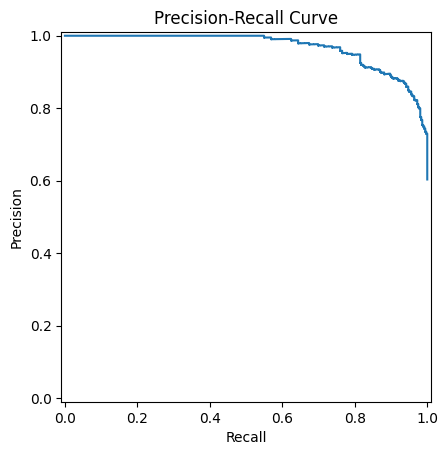



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 43 (Incorrect Conflations)
                                                   name  \
809   AdventHealth Medical Group Pediatric and Adult...   
2445                                        Star Market   
2602                    บริษัท ไทยสมเด็จ เซอร์วิส จำกัด   
2525                                          Starbucks   
863                      Produkta Motor Group Nelspruit   
1143                                           Speedway   
1973                                CFE Centro Xalostoc   
1116                        Perum Bumi Indah Proklamasi   
2571                               CIBC Branch with ATM   
1847                                            Walmart   

                                              base_name  \
809   AdventHealth Medical Group Cardiology at Winte...   
2445                               Star Market Pharmacy   
2602                     บริษัท ไทยสมเด็จเซอร์วิส จำกัด   
2525              

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.8972
  F1-Score (Non-US Data): 0.8876
  F1-Score (Missing Data): 0.7368
  Average F1 CV Score: 0.8928
  Accuracy: 0.8717
  Accuracy (Non-US Data): 0.8730
  Accuracy (Missing Data): 0.8387
  PR-AUC:   0.9684
  PR-AUC (Missing Data): 0.7873
  PR-AUC (Non-US Data): 0.9122
  Total Test Set Processing Time: 9.18s


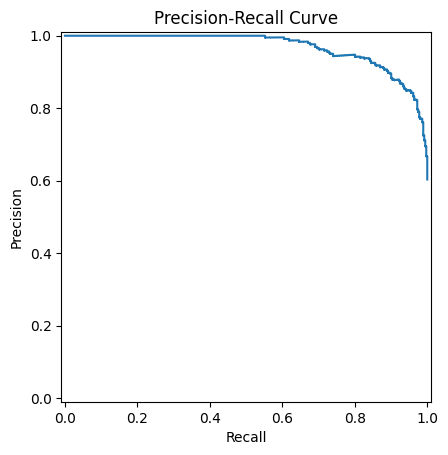



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 51 (Incorrect Conflations)
                                  name                              base_name  \
2046                           Panaria                                Panaria   
2784           Barmenia Versicherungen    Barmenia Versicherung - Thomas Harm   
2099           Barmenia Versicherungen  Barmenia Versicherung - Oliver Schulz   
2074     Gelateria Tropical Di Moretto                     Gelateria Tropical   
1938                            Subway                                 Subway   
2445                       Star Market                   Star Market Pharmacy   
1860                       Vinzenzmurr                            vinzenzmurr   
2619         Gemlik Hazar Erkek Kuaför                                 Gemlik   
407   Health Care Physicians Profile 1       Health Care Physicians Profile 6   
2926                  Wells Fargo Bank                        Wells Fargo ATM   

            

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Model loaded successfully.
Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.8991
  F1-Score (Non-US Data): 0.8958
  F1-Score (Missing Data): 0.8000
  Average F1 CV Score: 0.8981
  Accuracy: 0.8750
  Accuracy (Non-US Data): 0.8825
  Accuracy (Missing Data): 0.8710
  PR-AUC:   0.9652
  PR-AUC (Missing Data): 0.8323
  PR-AUC (Non-US Data): 0.9186
  Total Test Set Processing Time: 4.95s


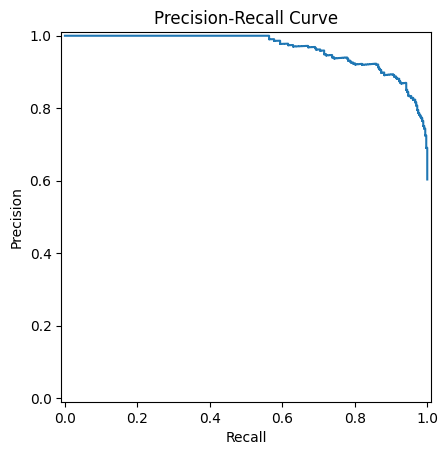



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 47 (Incorrect Conflations)
                                                   name  \
1825                                          Axis Bank   
718                         Blue Rhino Propane Exchange   
2697             Centro Espírita Jesus Cristo Humildade   
1990                                             Subway   
1866                                   Wells Fargo Bank   
863                      Produkta Motor Group Nelspruit   
1391  Keck Medicine of USC - USC Hematology Oncology...   
1956                             L' Atelier Du Chocolat   
2090                        Başakşehir 4. Etap 2. Kısım   
809   AdventHealth Medical Group Pediatric and Adult...   

                                              base_name  \
1825                                      Axis Bank ATM   
718                         Blue Rhino Propane Exchange   
2697           Centro Espírita Jesus Cristo é Humildade   
1990              

In [11]:
# sentence transformer model names on huggingface to test
small_models = [
    'intfloat/multilingual-e5-base',
    'BAAI/bge-m3',
    'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    'Alibaba-NLP/gte-multilingual-base',
    'google/embeddinggemma-300m',
    'Qwen/Qwen3-Embedding-0.6B',
    'intfloat/multilingual-e5-large'
]

# columns to embed for cosine similarity as features for the classifier
feature_list = ['name', 'category', 'address']

# discrete features for classifier
discrete_feature_list = [
    'phone_match', 'confidence_product', 'category_match', 'name_length_diff',
    'website_match', 'token_set_ratio', 'partial_ratio',
    'addr_partial_ratio', 'addr_token_set_ratio', 'name_word_diff'
]

# list to store all model results
results_list = []

for model_name in small_models:
    print(f"\n--- Testing Model: {model_name} ---")

    try:
        try:
            embedder = SentenceTransformer(model_name, device='cuda' if torch.cuda.is_available() else 'cpu', trust_remote_code=True)
        except NameError:
            embedder = SentenceTransformer(model_name, trust_remote_code=True)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model {model_name}: {e}. Skipping.")
        continue

    # generate semantic embeddings and similarities
    train_similarity_list = []
    test_similarity_list = []
    total_time = 0
    for feature in feature_list:
        train_similarity_list = train_similarity_list + process_feature(X_train, 'train', embedder, feature)

        # start total test set embedding time
        embed_time_start = time.perf_counter()
        test_similarity_list = test_similarity_list + process_feature(X_test, 'test', embedder, feature)

        # add total test set embedding time to counter
        total_time += time.perf_counter() - embed_time_start

    reshaped_train_sim = reshape_similarities(train_similarity_list)
    reshaped_test_sim = reshape_similarities(test_similarity_list)

    # stack Features ---
    X_train_final = reshape_and_stack_features(X_train, reshaped_train_sim, discrete_feature_list)
    X_test_final = reshape_and_stack_features(X_test, reshaped_test_sim, discrete_feature_list)

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1_scores = cross_val_score(
        classifier, X_train_final, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1
    )


    # train and evaluate classifier
    print("Training Gradient Boosting Classifier...")
    classifier.fit(X_train_final, y_train)


    eval_time_start = time.perf_counter()
    print("Evaluating on test set...")
    y_pred_proba = classifier.predict_proba(X_test_final)[:, 1]
    y_pred = classifier.predict(X_test_final)

    # add total test evaluation time to counter
    total_time += time.perf_counter() - eval_time_start

    # none US cases
    non_us_mask = (X_test['country'] != 'US')
    missing_data_mask = (X_test['address'] == '') | (X_test['name'] == '')

    # filter True and Predicted labels for Non-US rows
    y_test_non_us = y_test[non_us_mask]
    y_pred_non_us = y_pred[non_us_mask]

    y_test_missing_data = y_test[missing_data_mask]
    y_pred_missing_data = y_pred[missing_data_mask]

    # calculate F1 and accuracy for Non-US subset
    # check if the subset is empty before calculating to avoid errors
    if len(y_test_non_us) > 0:
        f1_non_us = f1_score(y_test_non_us, y_pred_non_us)
        accuracy_non_us = accuracy_score(y_test_non_us, y_pred_non_us)
        precision, recall, _ = precision_recall_curve(y_test_non_us, y_pred_non_us)
        pr_auc_non_us = auc(recall, precision)
    else:
        f1_non_us = np.nan
        accuracy_non_us = np.nan

    if len(y_test_missing_data) > 0:
        f1_missing_data = f1_score(y_test_missing_data, y_pred_missing_data)
        accuracy_missing_data = accuracy_score(y_test_missing_data, y_pred_missing_data)
        precision, recall, _ = precision_recall_curve(y_test_missing_data, y_pred_missing_data)
        pr_auc_missing_data = auc(recall, precision)
    else:
        f1_missing_data = np.nan
        accuracy_missing_data = np.nan

    # calculate metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    average_f1 = cv_f1_scores.mean()

    # display scores
    print(f"  F1-Score: {f1:.4f}")
    print(f"  F1-Score (Non-US Data): {f1_non_us:.4f}")
    print(f"  F1-Score (Missing Data): {f1_missing_data:.4f}")
    print(f"  Average F1 CV Score: {average_f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Accuracy (Non-US Data): {accuracy_non_us:.4f}")
    print(f"  Accuracy (Missing Data): {accuracy_missing_data:.4f}")
    print(f"  PR-AUC:   {pr_auc:.4f}")
    print(f"  PR-AUC (Missing Data): {pr_auc_missing_data:.4f}")
    print(f"  PR-AUC (Non-US Data): {pr_auc_non_us:.4f}")

    print(f"  Total Test Set Processing Time: {total_time:.2f}s")

    # save results to the list
    results_list.append({
        'Model Name': model_name,
        'F1-Score': f1,
        'F1-Score (Non-US)': f1_non_us,
        'F1-Score (Missing Data)': f1_missing_data,
        'Average F1 CV Scores': average_f1,
        'Accuracy': accuracy,
        'Accuracy (Non-US)': accuracy_non_us,
        'Accuracy (Missing Data)': accuracy_missing_data,
        'PR-AUC': pr_auc,
        'PR-AUC (Missing Data)': pr_auc_missing_data,
        'PR-AUC (Non-US Data)': pr_auc_non_us,
        'Total Test Time': total_time
      }),

    display = PrecisionRecallDisplay(precision=precision, recall=recall)
    display.plot()
    plt.title("Precision-Recall Curve")
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # 1. Identify False Positives (FP)
    fp_mask = (y_pred == 1) & (y_test == 0)

    print("\n\n--- FALSE POSITIVES (Model Merged Incorrectly) ---")
    print(f"Total FP count: {fp} (Incorrect Conflations)")

    if fp > 0:
        # Select key columns for inspection from the X_test features
        # X_test must contain the original string columns for this to work (name, address, etc.)
        fp_rows = X_test[fp_mask]
        print(fp_rows[['name', 'base_name', 'address', 'base_address']].sample(min(10, fp)))

    # 2. Identify False Negatives (FN)
    fn_mask = (y_pred == 0) & (y_test == 1)

    print("\n--- FALSE NEGATIVES (Model Missed a True Match) ---")
    print(f"Total FN count: {fn} (Missed Matches)")

    if fn > 0:
        # Select key columns for inspection from the X_test features
        fn_rows = X_test[fn_mask]
        print(fn_rows[['name', 'base_name', 'address', 'base_address']].sample(min(10, fn)))

    # display scores
    print(f"  False Positives (Incorrect Matches): {fp}")
    # ... (rest of the printing logic continues) ...


    del embedder
    gc.collect()
    torch.cuda.empty_cache()

# save results to a csv
print("\n" + "="*80)
print("All Evaluations Complete. Generating Summary CSV.")
print("="*80)
results_df = pd.DataFrame(results_list)

# display the final summary table
print("\n--- Summary of Model Performance ---")
print(results_df.sort_values(by='F1-Score', ascending=False).to_markdown(index=False, floatfmt=".4f"))

# save the DataFrame to a CSV file
output_csv_path = 'small_embedding_model_comparison_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nResults saved successfully to: **{output_csv_path}**")

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training Gradient Boosting Classifier...
Evaluating on test set...
  F1-Score: 0.9130
  F1-Score (Non-US Data): 0.9148
  F1-Score (Missing Data): 0.9000
  Average F1 CV Score: 0.8907
  Accuracy: 0.8933
  Accuracy (Non-US Data): 0.9048
  Accuracy (Missing Data): 0.9355
  PR-AUC:   0.9723
  PR-AUC (Missing Data): 0.9161
  PR-AUC (Non-US Data): 0.9341
  Total Test Set Processing Time: 4.42s


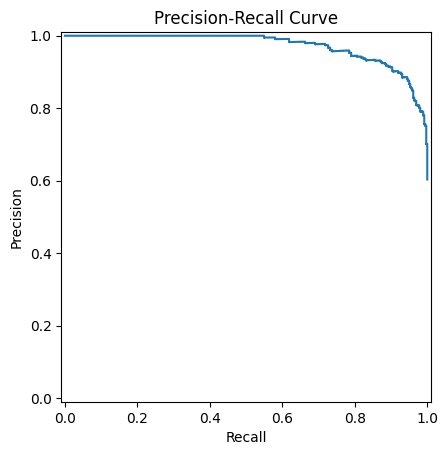



--- FALSE POSITIVES (Model Merged Incorrectly) ---
Total FP count: 38 (Incorrect Conflations)
                                                   name  \
1956                             L' Atelier Du Chocolat   
2602                    บริษัท ไทยสมเด็จ เซอร์วิส จำกัด   
1906                                         McDonald's   
2753                         U-Haul Neighborhood Dealer   
2490           Kreissparkasse Ludwigsburg - Geldautomat   
2637                                             Subway   
809   AdventHealth Medical Group Pediatric and Adult...   
2926                                   Wells Fargo Bank   
2945                   Diferencial Ensino Personalizado   
2697             Centro Espírita Jesus Cristo Humildade   

                                              base_name  \
1956                              L'Atelier Du Chocolat   
2602                     บริษัท ไทยสมเด็จเซอร์วิส จำกัด   
1906                                         McDonald's   
2753              

In [13]:
classifier = GradientBoostingClassifier(
    n_estimators=520, learning_rate=0.01, max_depth=6, subsample=0.7,
    max_features=0.7, min_samples_leaf=7, random_state=42
)

model1_name = 'Alibaba-NLP/gte-multilingual-base' # or google/embeddinggemma-300m
model2_name = 'google/embeddinggemma-300m'
model3_name = 'google/embeddinggemma-300m'
model1 = SentenceTransformer(model1_name, device='cuda' if torch.cuda.is_available() else 'cpu', trust_remote_code=True)
model2 = SentenceTransformer(model2_name, device='cuda' if torch.cuda.is_available() else 'cpu', trust_remote_code=True)
model3 = SentenceTransformer(model3_name, device='cuda' if torch.cuda.is_available() else 'cpu', trust_remote_code=True)
results_list = []
feature_list = ['name', 'category', 'address']

# discrete features for classifier
discrete_feature_list = [
    'phone_match', 'confidence_product', 'category_match', 'name_length_diff',
    'website_match', 'token_set_ratio', 'partial_ratio',
    'addr_partial_ratio', 'addr_token_set_ratio', 'name_word_diff'
]

def process_feature_mixed(X_set: pd.DataFrame, set_name: str, column: str) -> Tuple[Dict, List[np.ndarray], np.ndarray]:

    text_A = X_set[column].apply(lambda x: x.strip() if x else '')
    text_B = X_set["base_" + column].apply(lambda x: x.strip() if x else '')

    empty_mask = (text_A == '') & (text_B == '')

    instruction = ''
    emb = None
    base_emb = None
    # Different embedding format using multiple columns for address column
    if column == 'address':
      emb = model2.encode(
          (text_A + X_set['locality'] + X_set['region'] + X_set['country']).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=model2.device
      )
      base_emb = model2.encode(
          (text_B + X_set['base_locality'] + X_set['base_region'] + X_set['base_country']).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=model2.device
      )
    elif column == 'name':
      emb = model1.encode(
          (instruction + text_A).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=model1.device
      )
      base_emb = model1.encode(
          (instruction + text_B).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=model1.device
      )
    else:
      emb = model3.encode(
          (instruction + text_A).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=model3.device
      )
      base_emb = model3.encode(
          (instruction + text_B).tolist(),
          convert_to_tensor=True,
          show_progress_bar=False,
          device=model3.device
      )
    sim_scores = cos_sim(emb, base_emb).diag().cpu().numpy()

    return [sim_scores]


# generate semantic embeddings and similarities
train_similarity_list = []
test_similarity_list = []
total_time = 0
for feature in feature_list:
    train_similarity_list = train_similarity_list + process_feature_mixed(X_train, 'train', feature)

    # start total test set embedding time
    embed_time_start = time.perf_counter()
    test_similarity_list = test_similarity_list + process_feature_mixed(X_test, 'test', feature)

    # add total test set embedding time to counter
    total_time += time.perf_counter() - embed_time_start

reshaped_train_sim = reshape_similarities(train_similarity_list)
reshaped_test_sim = reshape_similarities(test_similarity_list)

# stack Features ---
X_train_final = reshape_and_stack_features(X_train, reshaped_train_sim, discrete_feature_list)
X_test_final = reshape_and_stack_features(X_test, reshaped_test_sim, discrete_feature_list)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1_scores = cross_val_score(
    classifier, X_train_final, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1
)


# train and evaluate classifier
print("Training Gradient Boosting Classifier...")
classifier.fit(X_train_final, y_train)


eval_time_start = time.perf_counter()
print("Evaluating on test set...")
y_pred_proba = classifier.predict_proba(X_test_final)[:, 1]
y_pred = classifier.predict(X_test_final)

# add total test evaluation time to counter
total_time += time.perf_counter() - eval_time_start

# none US cases
non_us_mask = (X_test['country'] != 'US')
missing_data_mask = (X_test['address'] == '') | (X_test['name'] == '')

# filter True and Predicted labels for Non-US rows
y_test_non_us = y_test[non_us_mask]
y_pred_non_us = y_pred[non_us_mask]

y_test_missing_data = y_test[missing_data_mask]
y_pred_missing_data = y_pred[missing_data_mask]

# calculate F1 and accuracy for Non-US subset
# check if the subset is empty before calculating to avoid errors
if len(y_test_non_us) > 0:
    f1_non_us = f1_score(y_test_non_us, y_pred_non_us)
    accuracy_non_us = accuracy_score(y_test_non_us, y_pred_non_us)
    precision, recall, _ = precision_recall_curve(y_test_non_us, y_pred_non_us)
    pr_auc_non_us = auc(recall, precision)
else:
    f1_non_us = np.nan
    accuracy_non_us = np.nan

if len(y_test_missing_data) > 0:
    f1_missing_data = f1_score(y_test_missing_data, y_pred_missing_data)
    accuracy_missing_data = accuracy_score(y_test_missing_data, y_pred_missing_data)
    precision, recall, _ = precision_recall_curve(y_test_missing_data, y_pred_missing_data)
    pr_auc_missing_data = auc(recall, precision)
else:
    f1_missing_data = np.nan
    accuracy_missing_data = np.nan

# calculate metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
average_f1 = cv_f1_scores.mean()

# display scores
print(f"  F1-Score: {f1:.4f}")
print(f"  F1-Score (Non-US Data): {f1_non_us:.4f}")
print(f"  F1-Score (Missing Data): {f1_missing_data:.4f}")
print(f"  Average F1 CV Score: {average_f1:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Accuracy (Non-US Data): {accuracy_non_us:.4f}")
print(f"  Accuracy (Missing Data): {accuracy_missing_data:.4f}")
print(f"  PR-AUC:   {pr_auc:.4f}")
print(f"  PR-AUC (Missing Data): {pr_auc_missing_data:.4f}")
print(f"  PR-AUC (Non-US Data): {pr_auc_non_us:.4f}")

print(f"  Total Test Set Processing Time: {total_time:.2f}s")

# save results to the list
results_list.append({
    'Model Name': 'Mixed',
    'F1-Score': f1,
    'F1-Score (Non-US)': f1_non_us,
    'F1-Score (Missing Data)': f1_missing_data,
    'Average F1 CV Scores': average_f1,
    'Accuracy': accuracy,
    'Accuracy (Non-US)': accuracy_non_us,
    'Accuracy (Missing Data)': accuracy_missing_data,
    'PR-AUC': pr_auc,
    'PR-AUC (Missing Data)': pr_auc_missing_data,
    'PR-AUC (Non-US Data)': pr_auc_non_us,
    'Total Test Time': total_time
  }),

display = PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()
plt.title("Precision-Recall Curve")
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# 1. Identify False Positives (FP)
fp_mask = (y_pred == 1) & (y_test == 0)

print("\n\n--- FALSE POSITIVES (Model Merged Incorrectly) ---")
print(f"Total FP count: {fp} (Incorrect Conflations)")

if fp > 0:
    # Select key columns for inspection from the X_test features
    # X_test must contain the original string columns for this to work (name, address, etc.)
    fp_rows = X_test[fp_mask]
    print(fp_rows[['name', 'base_name', 'address', 'base_address']].sample(min(10, fp)))

# 2. Identify False Negatives (FN)
fn_mask = (y_pred == 0) & (y_test == 1)

print("\n--- FALSE NEGATIVES (Model Missed a True Match) ---")
print(f"Total FN count: {fn} (Missed Matches)")

if fn > 0:
    # Select key columns for inspection from the X_test features
    fn_rows = X_test[fn_mask]
    print(fn_rows[['name', 'base_name', 'address', 'base_address']].sample(min(10, fn)))

del model1
del model2
gc.collect()
torch.cuda.empty_cache()

# save results to a csv
print("\n" + "="*80)
print("All Evaluations Complete. Generating Summary CSV.")
print("="*80)
results_df = pd.DataFrame(results_list)

# display the final summary table
print("\n--- Summary of Model Performance ---")
print(results_df.sort_values(by='F1-Score', ascending=False).to_markdown(index=False, floatfmt=".4f"))

# save the DataFrame to a CSV file
output_csv_path = 'mixed_model_comparison_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nResults saved successfully to: **{output_csv_path}**")

Same as the small model test, but with params larger than ~1B (Run with large GPU)

In [ ]:
large_models = ['nvidia/llama-embed-nemotron-8b', 'Qwen/Qwen3-Embedding-4B', 'Qwen/Qwen3-Embedding-8B']
feature_list = ['name', 'category', 'address']
discrete_feature_list = [
    'phone_match', 'category_match', 'name_length_diff',
    'website_match', 'token_set_ratio', 'partial_ratio',
    'addr_partial_ratio', 'addr_token_set_ratio', 'name_word_diff'
]

# list to store all model results
results_list = []

for model_name in large_models:
    print(f"\n--- Testing Model: {model_name} ---")

    try:
        try:
            embedder = SentenceTransformer(model_name, device='cuda' if torch.cuda.is_available() else 'cpu', trust_remote_code=True)
        except NameError:
            embedder = SentenceTransformer(model_name, trust_remote_code=True)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model {model_name}: {e}. Skipping.")
        continue

    # generate semantic embeddings and similarities
    train_similarity_list = []
    test_similarity_list = []
    total_time = 0
    for feature in feature_list:
        train_similarity_list = train_similarity_list + process_feature(X_train, 'train', embedder, feature)

        # start total test set embedding time
        embed_time_start = time.perf_counter()
        test_similarity_list = test_similarity_list + process_feature(X_test, 'test', embedder, feature)

        # add total test set embedding time to counter
        total_time += time.perf_counter() - embed_time_start

    reshaped_train_sim = reshape_similarities(train_similarity_list)
    reshaped_test_sim = reshape_similarities(test_similarity_list)

    # stack Features ---
    X_train_final = reshape_and_stack_features(X_train, reshaped_train_sim, discrete_feature_list)
    X_test_final = reshape_and_stack_features(X_test, reshaped_test_sim, discrete_feature_list)

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1_scores = cross_val_score(
        classifier, X_train_final, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1
    )

    # train and evaluate classifier
    print("Training Gradient Boosting Classifier...")
    classifier.fit(X_train_final, y_train)


    eval_time_start = time.perf_counter()
    print("Evaluating on test set...")
    y_pred_proba = classifier.predict_proba(X_test_final)[:, 1]
    y_pred = classifier.predict(X_test_final)

    # add total test evaluation time to counter
    total_time += time.perf_counter() - eval_time_start

    # calculate metrics
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    average_f1 = cv_f1_scores.mean()

    # none US cases
    non_us_mask = (X_test['country'] != 'US')
    missing_data_mask = (X_test['address'] == '') | (X_test['name'] == '')

    # filter True and Predicted labels for Non-US rows
    y_test_non_us = y_test[non_us_mask]
    y_pred_non_us = y_pred[non_us_mask]

    y_test_missing_data = y_test[missing_data_mask]
    y_pred_missing_data = y_pred[missing_data_mask]

    # calculate F1 and accuracy for Non-US subset
    # check if the subset is empty before calculating to avoid errors
    if len(y_test_non_us) > 0:
        f1_non_us = f1_score(y_test_non_us, y_pred_non_us)
        accuracy_non_us = accuracy_score(y_test_non_us, y_pred_non_us)
    else:
        f1_non_us = np.nan
        accuracy_non_us = np.nan

    if len(y_test_non_us) > 0:
        f1_missing_data = f1_score(y_test_missing_data, y_pred_missing_data)
        accuracy_missing_data = accuracy_score(y_test_missing_data, y_pred_missing_data)
    else:
        f1_missing_data = np.nan
        accuracy_missing_data = np.nan

    # display scores
    print(f"  F1-Score: {f1:.4f}")
    print(f"  F1-Score (Non-US Data): {f1_non_us:.4f}")
    print(f"  F1-Score (Missing Data): {f1_missing_data:.4f}")
    print(f"  Average F1 CV Score: {average_f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Accuracy (Non-US Data): {accuracy_non_us:.4f}")
    print(f"  Accuracy (Missing Data): {accuracy_missing_data:.4f}")
    print(f"  PR-AUC:   {pr_auc:.4f}")
    print(f"  Total Test Set Processing Time: {total_time:.2f}s")

    # save results to the list
    results_list.append({
        'Model Name': model_name,
        'F1-Score': f1,
        'F1-Score (Non-US)': f1_non_us,
        'F1-Score (Missing Data)': f1_missing_data,
        'Average F1 CV Scores': average_f1,
        'Accuracy': accuracy,
        'Accuracy (Non-US)': accuracy_non_us,
        'Accuracy (Missing Data)': accuracy_missing_data,
        'PR-AUC': pr_auc,
        'Total Test Time': total_time
      }),

    del embedder
    gc.collect()
    torch.cuda.empty_cache()

# create and save csv
print("\n" + "="*80)
print("All Evaluations Complete. Generating Summary CSV.")
print("="*80)
results_df = pd.DataFrame(results_list)

# display the final summary table
print("\n--- Summary of Model Performance ---")
print(results_df.sort_values(by='F1-Score', ascending=False).to_markdown(index=False, floatfmt=".4f"))

# save the DataFrame to a CSV file
output_csv_path = 'large_embedding_model_comparison_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nResults saved successfully to: **{output_csv_path}**")
